In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,894 cases (7 day average) as of Sat 22 May, +39.7 since Fri 21 May
88 hospitalised (7 day average) as of Mon 24 May, +3.4 since Sun 23 May
4 died (7 day average) as of Sat 22 May, -0.6 since Fri 21 May


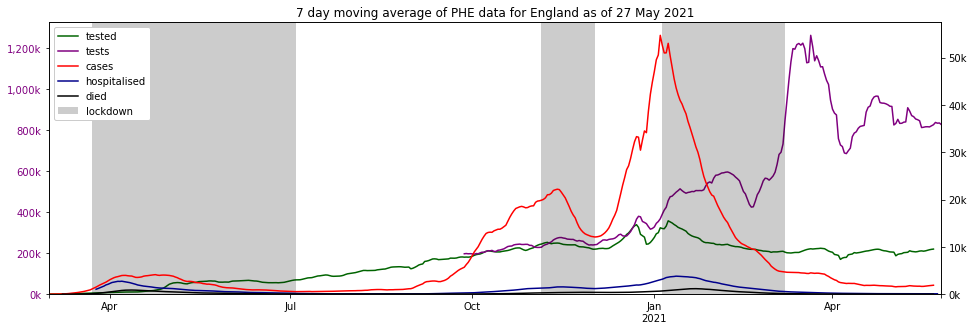

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

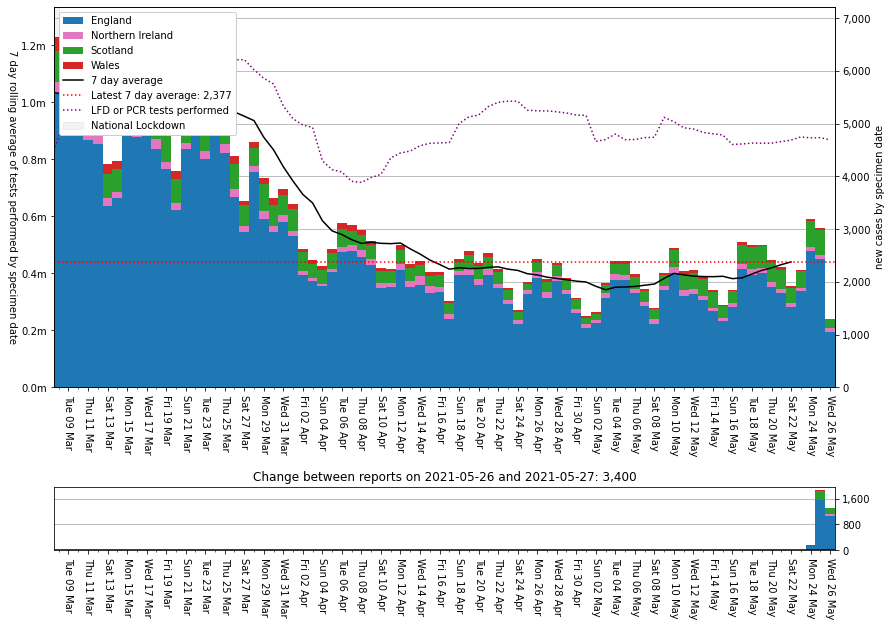

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

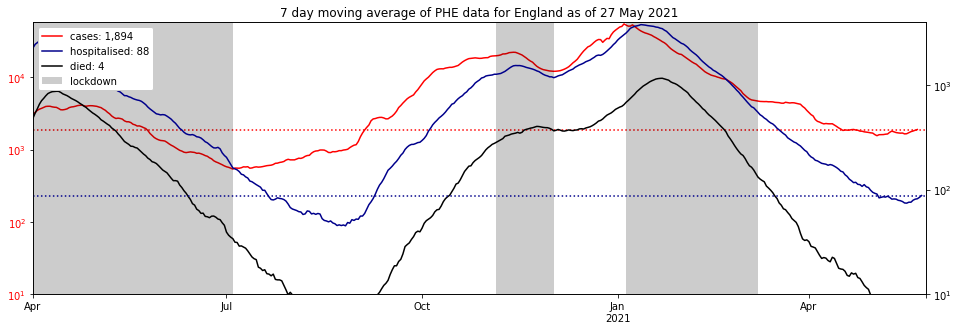

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

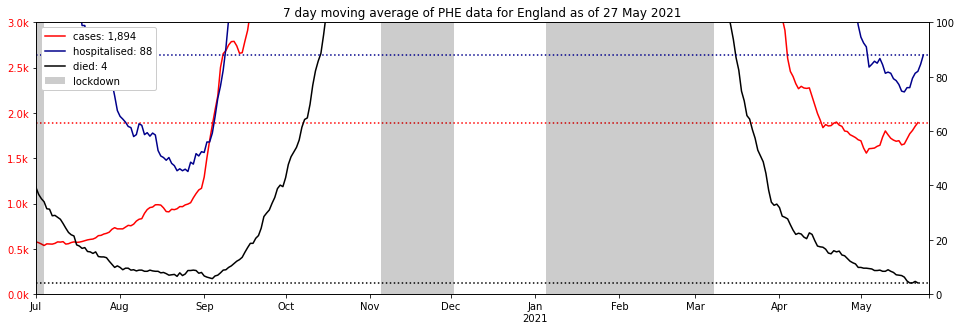

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,26 May 21,"+20,403,324","+32,285,684","+20,403,324","+368,554","+206,311","+368,554"
Northern Ireland,26 May 21,"+639,883","+1,034,143","+639,883","+9,713","+3,332","+9,713"
Scotland,26 May 21,"+1,942,285","+3,174,807","+1,942,285","+28,476","+19,074","+28,476"
Wales,26 May 21,"+1,058,464","+2,120,049","+1,058,464","+20,715","+7,402","+20,715"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,20403324.0,32285684.0,11882360.0,56286961,36.248758,21.110324,42.640918
1,Northern Ireland,N92000002,639883.0,1034143.0,394260.0,1893667,33.790682,20.819922,45.389395
2,Scotland,S92000003,1942285.0,3174807.0,1232522.0,5463300,35.551498,22.560028,41.888474
3,Wales,W92000004,1058464.0,2120049.0,1061585.0,3152879,33.571349,33.670337,32.758314


'partial: 38,614,683 (57.8%), full: 24,043,956'

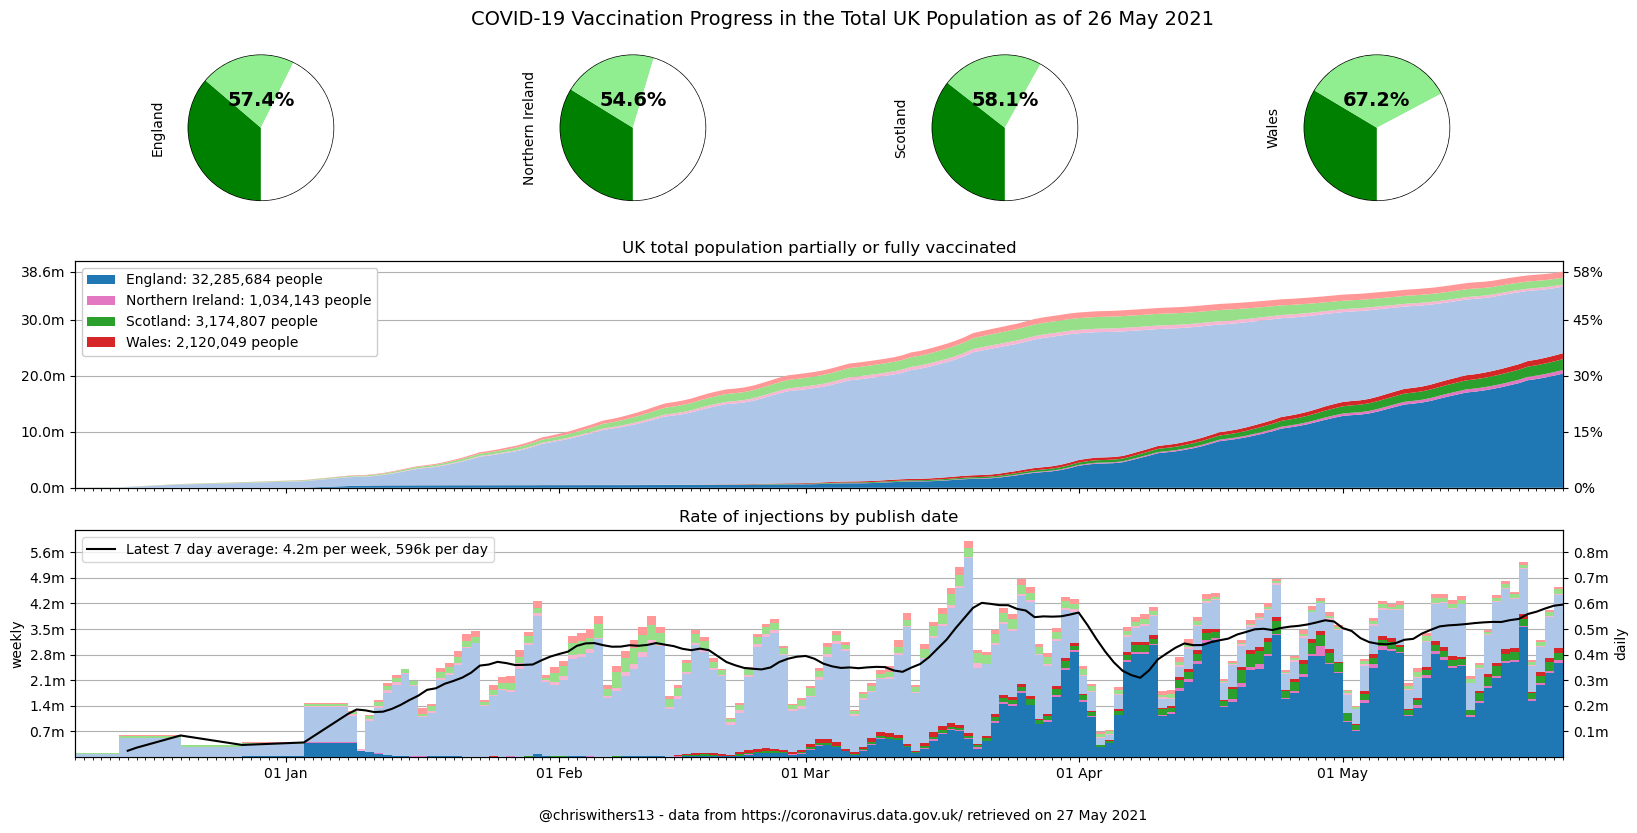

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

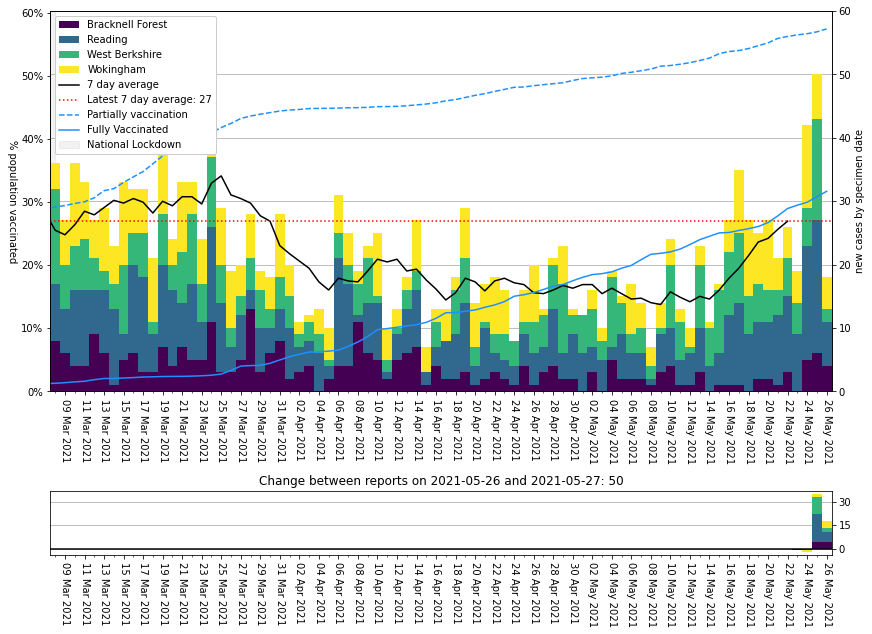

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60,  lines=population_vaccinated)

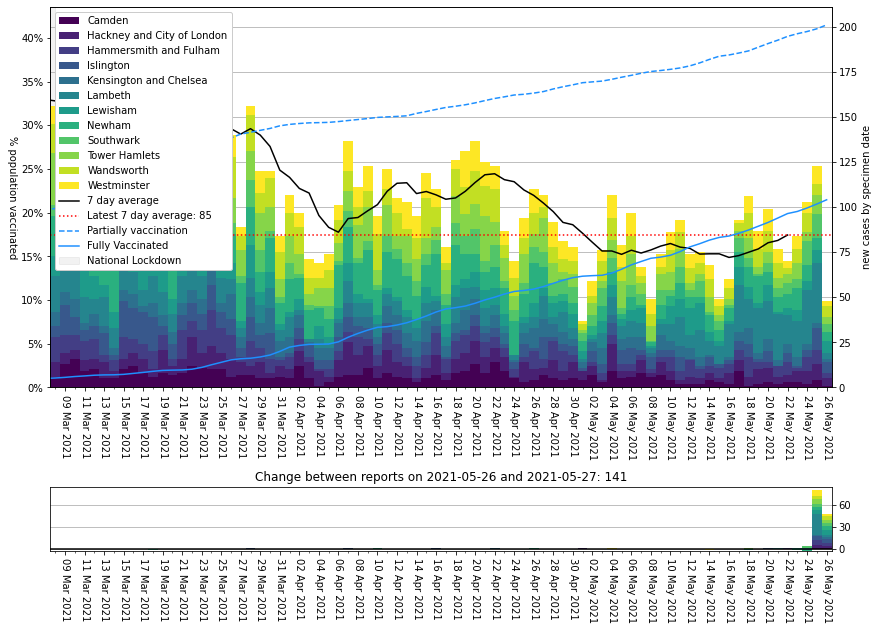

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,325.325994,487.0,2021-05-26
E08000001,Bolton,316.814467,911.0,2021-05-26
E07000125,Rossendale,246.215831,176.0,2021-05-26
E06000055,Bedford,152.921081,265.0,2021-05-26
S12000049,Glasgow City,118.145059,748.0,2021-05-26
S12000011,East Renfrewshire,108.866325,104.0,2021-05-26
S12000005,Clackmannanshire,108.653473,56.0,2021-05-26
E07000120,Hyndburn,106.116506,86.0,2021-05-26
S12000038,Renfrewshire,104.969291,188.0,2021-05-26


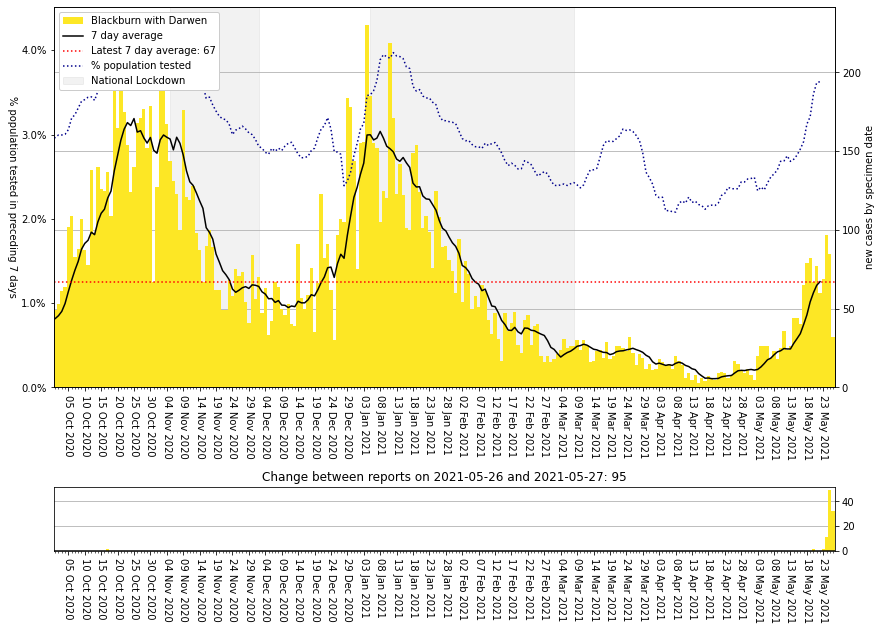

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,316.814467,911.0,2021-05-26
S12000049,Glasgow City,118.145059,748.0,2021-05-26
E06000008,Blackburn with Darwen,325.325994,487.0,2021-05-26
E08000034,Kirklees,95.728159,421.0,2021-05-26
E08000003,Manchester,72.893944,403.0,2021-05-26
E08000025,Birmingham,28.463430,325.0,2021-05-26
E08000032,Bradford,51.688108,279.0,2021-05-26
E06000055,Bedford,152.921081,265.0,2021-05-26
S12000036,City of Edinburgh,50.101918,263.0,2021-05-26


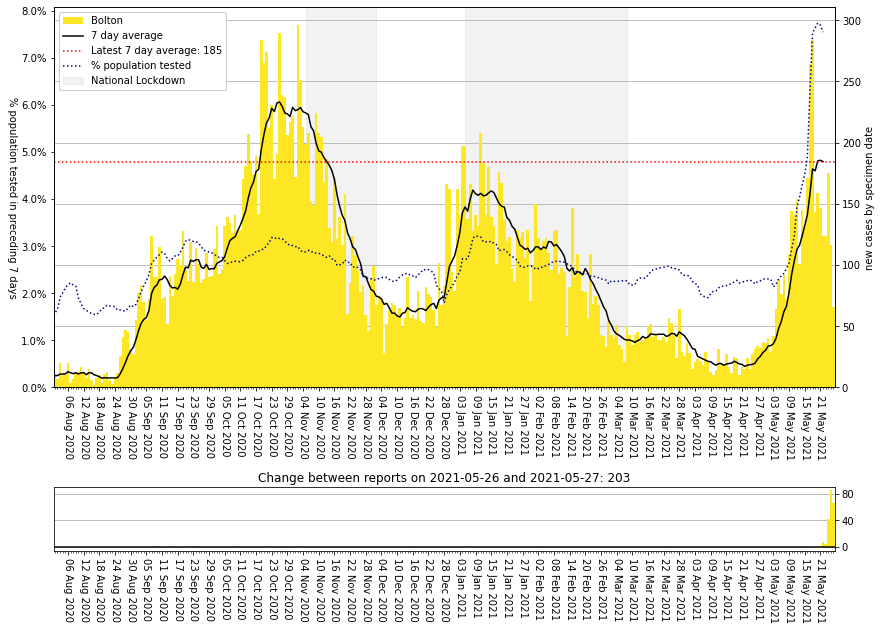

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested, earliest='2020-08')

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

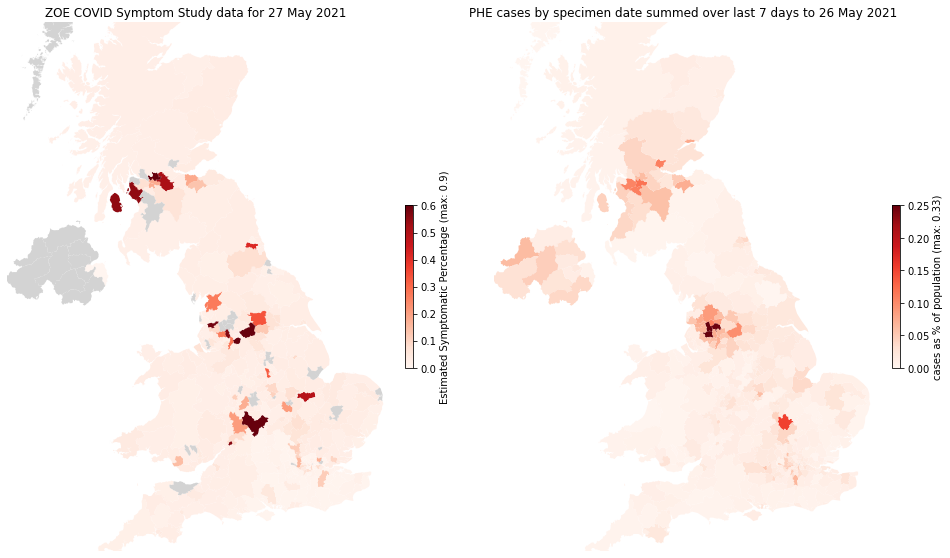

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...